# Random Acts of Pizza

The objective of the project is to predict if the requester on Reddit will receive a Pizza as an act of altruism from one of the other Reddit users. 
The train and test data files are available in kaggle.com and have been downloaded at the below location before executing this notebook. 
We apply some text processing techniques below on the requester text. We basically use both CountVectorizer and TfIdfVectorizer with multiple options of parameters.

In [ ]:
%matplotlib inline

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [37]:
# We split the train and dev datasets roughly 75/25
data = pd.read_json("/Users/gautamkarnataki/MIDS/train.json")
train_data = data[:3500]["request_text"]
train_labels = data[:3500]["requester_received_pizza"]
dev_data = data[3501:]["request_text"]
dev_labels = data[3501:]["requester_received_pizza"]
data.head(3)

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,0,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.0000,...,False,[],0,1,0,1,None,nickylvst,1317852607,1317849007
1,N/A,2,5,0,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.1111,...,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1332652424,1332648824
2,N/A,0,3,0,t3_lpu5j,0,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.0000,...,False,[],0,3,0,3,None,jacquibatman7,1319650094,1319646494


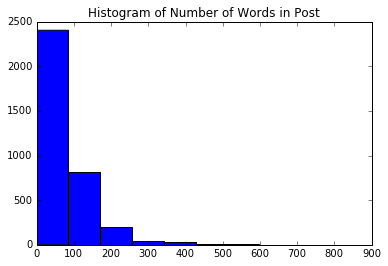

,# of Words
count,3500.000000
mean,78.094571
std,73.007565
min,0.000000
25%,35.000000
50%,59.000000
75%,97.250000
max,854.000000


In [38]:
post_lengths = []
for post in train_data:
    post_lengths.append(len(post.split()))
post_length_np = np.array(post_lengths)
plt.hist(post_length_np)
plt.title("Histogram of Number of Words in Post")
plt.show()
pd.DataFrame(data = {'# of Words': post_length_np}).describe()

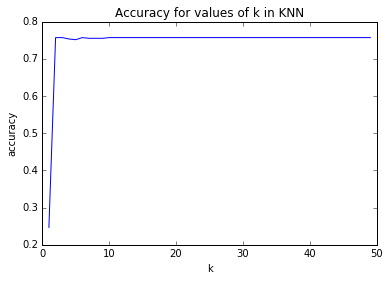

optimal k =  2
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')
    accuracy  = 0.757
    f1 scores =  [ 0.86166843  0.        ]


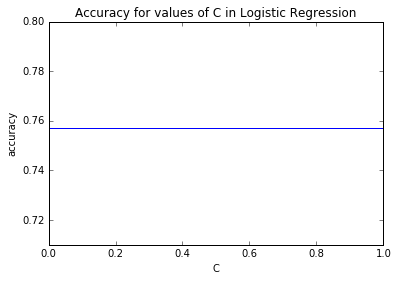

optimal C =  0.001
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
    accuracy  =  0.756957328386


In [42]:
# Method to search for an optimal k for a K Nearest Neighbor vectorizer
def knn_optimal_k(vectorizer,train_data,train_labels,dev_data,dev_labels, \
                      k_values=np.arange(1,50)):
    train_data_vectorized = vectorizer.fit_transform(train_data)
    dev_data_vectorized = vectorizer.transform(dev_data)
    
    # Fit K-Nearest Neighbor
    accuracies = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train_data_vectorized,train_labels)
        accuracy = knn.score(dev_data_vectorized,dev_labels)
        accuracies.append(accuracy)
        #print knn
        #print "accuracy = ",accuracy

    plt.plot(k_values,accuracies)
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.title('Accuracy for values of k in KNN')
    plt.show()    
        
    optimal_k = k_values[accuracies.index(max(accuracies))]
    print "optimal k = ",optimal_k
    
    knn = KNeighborsClassifier(n_neighbors=optimal_k)
    knn.fit(train_data_vectorized,train_labels)
    y_pred = knn.predict(dev_data_vectorized)
    print knn
    print"    accuracy  = %2.3f" % (max(accuracies))
    print"    f1 scores = ", metrics.f1_score(dev_labels, y_pred,average=None)
    
    
def log_res_optimal_C(vectorizer,train_data,train_labels,dev_data,dev_labels, \
                      C_list=[0.001, 0.01, 0.1, 0.5, 1.0]):
    train_data_vectorized = vectorizer.fit_transform(train_data)
    dev_data_vectorized = vectorizer.transform(dev_data)
    
    accuracies = []
    for C in C_list:
        lr = LogisticRegression(C=C).fit(train_data_vectorized,train_labels)
        accuracy = lr.score(dev_data_vectorized,dev_labels)
        accuracies.append(accuracy)
        #print lr
        #print "accuracy =",accuracy
        #print

    plt.plot(C_list,accuracies)
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.title('Accuracy for values of C in Logistic Regression')
    plt.show()
   
    optimal_C = C_list[accuracies.index(max(accuracies))]
    print "optimal C = ",optimal_C
    lr = LogisticRegression(C=optimal_C).fit(train_data_vectorized,train_labels)
    print lr
    print "    accuracy  = ",max(accuracies)
    
knn_optimal_k(cv,train_data,train_labels,dev_data,dev_labels)
log_res_optimal_C(cv,train_data,train_labels,dev_data,dev_labels)

In [25]:
# Use basic pre-processing techniques
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def no_preprocessor(s):
    return s

def better_preprocessor(s):
    message = s.lower()
    message = re.sub(r"[^a-zA-Z0-9]", " ", message)
    message = re.sub(r"[-]*", "", message)
    message = ' '.join([word[0:8] for word in message.split()])
    return message

def stemming_tokenizer(str_input):
    words = str_input.split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In each of the cases below, while the accuracy is above 70%, we are seeing that none of the cases in the dev dataset are being predicted as 'True'. This could be because of the skewness in the training dataset - where more than 70% of the cases are 'False'.
This suggests a major problem in the training dataset. Of the two classes, the dataset is biased towards one of them.

In [32]:
cv = TfidfVectorizer(stop_words='english')
transformer = cv.fit_transform(train_data)
classifier = KNeighborsClassifier(n_neighbors=8)
classifier.fit(transformer,train_labels)
dev_data_trans = cv.transform(dev_data)
y_pred = classifier.predict(dev_data_trans)
print "Default F1-score (on dev set): %.4f" % metrics.accuracy_score(y_true=dev_labels, y_pred=y_pred)
print metrics.classification_report(y_true=dev_labels, y_pred=y_pred)

Default F1-score (on dev set): 0.7570
             precision    recall  f1-score   support

      False       0.76      1.00      0.86       408
       True       0.00      0.00      0.00       131

avg / total       0.57      0.76      0.65       539



/Users/gautamkarnataki/anaconda/envs/dato-env/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
cv = CountVectorizer(stop_words='english',preprocessor=better_preprocessor,tokenizer=stemming_tokenizer,ngram_range=(1,2))
transformer = cv.fit_transform(train_data)
classifier = LogisticRegression(C=0.001)
classifier.fit(transformer,train_labels)
dev_data_trans = cv.transform(dev_data)
y_pred = classifier.predict(dev_data_trans)
print "Default F1-score (on dev set): %.4f" % metrics.accuracy_score(y_true=dev_labels, y_pred=y_pred)
print metrics.classification_report(y_true=dev_labels, y_pred=y_pred)

Default F1-score (on dev set): 0.7570
             precision    recall  f1-score   support

      False       0.76      1.00      0.86       408
       True       0.00      0.00      0.00       131

avg / total       0.57      0.76      0.65       539



In [34]:
cv = TfidfVectorizer(stop_words='english',preprocessor=no_preprocessor,tokenizer=stemming_tokenizer,ngram_range=(1,1))
transformer = cv.fit_transform(train_data)
classifier = LogisticRegression(C=0.01)
classifier.fit(transformer,train_labels)
dev_data_trans = cv.transform(dev_data)
y_pred = classifier.predict(dev_data_trans)
print "Default F1-score (on dev set): %.4f" % metrics.accuracy_score(y_true=dev_labels, y_pred=y_pred)
print metrics.classification_report(y_true=dev_labels, y_pred=y_pred)

Default F1-score (on dev set): 0.7570
             precision    recall  f1-score   support

      False       0.76      1.00      0.86       408
       True       0.00      0.00      0.00       131

avg / total       0.57      0.76      0.65       539



The training dataset has been split in a better way in the function tf_idf_logreg2 below. While there is a drop in accuracy, the confusion matrix shows better precision and recall numbers across all classes.

In [29]:
def tf_idf_logreg1():
    data = pd.read_json("/Users/gautamkarnataki/MIDS/train.json")
    train_data = data[:3500]["request_text"]
    train_labels = data[:3500]["requester_received_pizza"]
    dev_data = data[3501:]["request_text"]
    dev_labels = data[3501:]["requester_received_pizza"]
    cv = TfidfVectorizer(stop_words='english',
                     preprocessor=better_preprocessor,
                     lowercase=True,
                     tokenizer=stemming_tokenizer,
                     min_df=2, 
                     max_df=0.5, 
                     ngram_range=(1,3))
    transformer = cv.fit_transform(train_data)
    classifier = LogisticRegression()
    classifier.fit(transformer,train_labels)
    dev_data_trans = cv.transform(dev_data)
    y_pred = classifier.predict(dev_data_trans)
    print "Accuracy (on dev set): %.4f" % metrics.accuracy_score(y_true=dev_labels, y_pred=y_pred)
    print metrics.classification_report(y_true=dev_labels, y_pred=y_pred)
    
def tf_idf_logreg2():
    data = pd.read_json("/Users/gautamkarnataki/MIDS/train.json")
    all_data = data[data["requester_received_pizza"]==True].iloc[0:1000]
    all_data = all_data.append(data[data["requester_received_pizza"]==False].iloc[0:1000])
    all_data = all_data.sample(frac=1)
    train_data = all_data[:1900]["request_text"]
    train_labels = all_data[:1900]["requester_received_pizza"]
    dev_data = all_data[1901:]["request_text"]
    dev_labels = all_data[1901:]["requester_received_pizza"]
    cv = TfidfVectorizer(stop_words='english',
                     preprocessor=better_preprocessor,
                     lowercase=True,
                     tokenizer=stemming_tokenizer,
                     min_df=2, 
                     max_df=0.5, 
                     ngram_range=(1,3))
    transformer = cv.fit_transform(train_data)
    classifier = LogisticRegression()
    classifier.fit(transformer,train_labels)
    dev_data_trans = cv.transform(dev_data)
    y_pred = classifier.predict(dev_data_trans)
    print "Accuracy (on dev set): %.4f" % metrics.accuracy_score(y_true=dev_labels, y_pred=y_pred)
    print metrics.classification_report(y_true=dev_labels, y_pred=y_pred)

    
tf_idf_logreg1()
tf_idf_logreg2()

Accuracy (on dev set): 0.7551
             precision    recall  f1-score   support

      False       0.76      1.00      0.86       408
       True       0.00      0.00      0.00       131

avg / total       0.57      0.76      0.65       539

Accuracy (on dev set): 0.5806
             precision    recall  f1-score   support

      False       0.54      0.50      0.52        42
       True       0.61      0.65      0.63        51

avg / total       0.58      0.58      0.58        93



### Baseline:


This deliverable is a baseline deliverable where we have just extracted the text data from the training set and trained converted the data into both count based and tf-idf based vectors. We have then tried some basic classification algorithms. 

We also tried a couple of ways of splitting the data and learnt that the training data is biased towards negetive cases.

### Future Work

Over the next few weeks we want to try some more techniques on this dataset:
1. Use combination of text and other features in the dataset
2. Create features that reflect the 'tone' of the text from these features e.g. politeness etc.
3. Find out if users are more sympathetic towards other similar users by using the 'requester_subreddits_at_request' attribute
4. Detect if limitations in vocabulary improves the accuracy/ROC
5. Find more effective ways of doing the train/dev split. We can see that train.json only has about 4000 datapoints. We want to try out if we can use the generative abilities of the Naive Bayes model to generate more data

### References

1. How to Ask for a Favor: A Case Study on the Success of Altruistic Requests: https://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf
2. https://slate.com/technology/2014/05/researchers-at-stanford-analyzed-random-acts-of-pizza-posts-on-reddit.html
3. https://www.huffingtonpost.com/2014/06/04/free-pizza-study-stanford-study_n_5441068.html
4. https://blog.algorithmia.com/introduction-natural-language-processing-nlp/